In [528]:
import zipfile
import pandas as pd
import numpy as np
import pickle
import random

from IPython.display import HTML, display, Markdown
from tabulate import tabulate

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [529]:
import pathlib
from pathlib import Path

name_file = 'course_project.zip'
 
#Получаем строку, содержащую путь к рабочей директории:
dir_path = pathlib.Path.cwd()
 
# Объединяем полученную строку с недостающими частями пути
path = Path(dir_path, name_file)
 
# выведем значение переменной path:
print(f'Путь к архиву: {str(path)}')

Путь к архиву: C:\Users\user\NumpyPandas\course_project.zip


In [530]:
file = []
with zipfile.ZipFile(name_file, 'r') as myzyp:
    for item in myzyp.infolist():
        print(item.filename)
        file.append(item.filename)

course_project_test.csv
course_project_train.csv


In [531]:
archive = path
with zipfile.ZipFile(archive, 'r') as zip_file:
    zip_file.extractall()

In [532]:
dir_path_df = pathlib.Path.cwd()
test_path = Path(dir_path_df, file[0])
train_path = Path(dir_path_df, file[1])
print(f'Пути к распакованым файлам из архива: {str(test_path), str(train_path)}')

Пути к распакованым файлам из архива: ('C:\\Users\\user\\NumpyPandas\\course_project_test.csv', 'C:\\Users\\user\\NumpyPandas\\course_project_train.csv')


In [533]:
TEST_DATASET_PATH = test_path
TRAIN_DATASET_PATH = train_path

df_test = pd.read_csv(TEST_DATASET_PATH, sep=',')
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_base = pd.read_csv(TRAIN_DATASET_PATH,sep=',')

#### Содержание датасета

* **Home Overship** - Владение недвижимостью (1 = Home Mortgage - Жильё в ипотеку, 2 = Rent - Снимает жильё, 3 = Own Home - Собственный дом, 4 = Have Mortgage - Ипотечное жильё
* **Annual Income** - Годовой доход
* **Years in current job** - Стаж текущего места работы
* **Tax Liens** - Залог
* **Number of Open Accounts** - Количество открытых счетов
* **Years of Credit History** - Кредитная история
* **Maximum Open Credit** - Максимальная сумма открытых кредитов
* **Number of Credit Problems** - Количество проблем с кредитованием
* **Months since last delinquent** - Месяцы с момента последнего нарушения
* **Bankruptcies** - Банкротство
* **Purpose** - Цель кредита
* **Term** - Займ (0 = Short Term - Кроткосрочный, 1 = Long Term - Долгосрочный)
* **Current Loan Amount** - Текущая сумма кредита
* **Current Credit Balance** - Текущий кредитный баланс
* **Monthly Debt** - Ежемесячный долг
* **Credit Score** - Кредитоспособность

#### Функции для построения графиков

In [681]:
def Box_plot(DF, w=6, h=3):
    plt.figure(figsize=(w, h))
    sns.boxplot(DF, whis=1.5)
    plt.show()

def Hist_info (DF, exclude):
    df_num_features = DF.select_dtypes(include=['float64', 'int64'])
    df_num_features.drop(exclude, axis=1, inplace=True)
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);

def Cross_Vall(DF, t=0.3):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.2)

    corr_matrix = DF.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < t] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')
    plt.show()
    
def Hist_info_tets (DF):
    df_num_features = DF.select_dtypes(include=['float64', 'int64'])
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);
    
def HIST (DF, b=50, w=16, h=8):
    DF.hist(figsize=(w, h), bins=b, grid=False);
    
def Graff(col1, col2, w=9, h=9):
    '''col1 and col2: write as >> df['name_col']'''
    grid = sns.jointplot(col1, col2, kind='reg')
    grid.fig.set_figwidth(w)
    grid.fig.set_figheight(h)
    plt.show()
    
def evaluate_preds(true_values, pred_values, max_x=10000, max_y=10000):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, max_x], [0, max_y], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()
    
def Mean_Median_Mode(DF, q_min=0.01, q_max=0.99, y_max=1, divisor=1e-6, b=50, w=16, h=8, ret=0, show=1):
    '''If ret = 1 then func return (target_mean, target_median, target_mode, quant_min, quant_max)
        show = 1 then func show graff'''
    
    target_mean = round(DF.mean(), 2)
    target_median = DF.median()
    target_mode = DF.mode()[0]
    y_max_div = y_max*divisor
    quant_min = round(np.quantile(DF, q=q_min),1)
    quant_max = round(np.quantile(DF, q=q_max),1)
    
    if show == 1:
        plt.figure(figsize = (w, h))

        sns.distplot(DF, bins=b)

        y = np.linspace(0, y_max_div, 10)
        plt.plot([target_mean] * 10, y, label=f'mean {target_mean}', linestyle=':', linewidth=4)
        plt.plot([target_median] * 10, y, label=f'median {target_median}', linestyle='--', linewidth=4)
        plt.plot([target_mode] * 10, y, label=f'mode {target_mode}', linestyle='-.', linewidth=4)
        plt.plot([quant_min] * 10, y, label=f'quant {q_min}={quant_min}', linestyle='solid', linewidth=2)
        plt.plot([quant_max] * 10, y, label=f'quant {q_max}={quant_max}', linestyle='solid', linewidth=2)

        plt.title(f'Distribution of {DF.name}')
        plt.legend()
        plt.show()
    if ret == 1:
        return target_mean, target_median, target_mode, quant_min, quant_max

def Object_columns(DF):
    obj_columns = [key for key, val in DF.dtypes.items() if val == object]
    return obj_columns

def Nan_columns(DF):
    nan_col = {}
    for key, val in df_train.isna().sum().items():
        if val > 0:
            nan_col[key] = val
    return nan_col

def build_model_nan(DF, columns, feature):
    X = DF[DF[feature].notnull()][columns]
    y = DF[DF[feature].notnull()][feature]
    model = LinearRegression()
    model.fit(X, y)
    return model

def predict_model_nan(DF, model, columns, feature):
    X = DF[DF[feature].isnull()][columns]
    y = model.predict(X)
    return y

def build_mode_outliers(DF, columns, feature):
    X = DF[columns]
    y = DF[feature]
    model = LinearRegression()
    model.fit(X, y)
    return model

def predict_model_outliers(DF, model, columns, feature):
    X = DF[columns]
    y = model.predict(X)
    return y

def clear_data(DF, columns, q_min=0.01, q_max=0.99):
    for col in columns:
        quant_min = round(np.quantile(DF[col], q=q_min),1)
        quant_max = round(np.quantile(DF[col], q=q_max),1)
        val = len(DF.loc[(DF[col] < quant_min) | (DF[col] > quant_max), col])
        result = round(val / DF.shape[0] * 100, 2)
        if result >= 4:
            model = build_mode_outliers(DF[(DF[col] > quant_min) & (DF[col] < quant_max)], columns, col)
            DF.loc[(DF[col] < quant_min) | (DF[col] > quant_max), col] = predict_model_outliers(DF[(DF[col] < quant_min) | (DF[col] > quant_max)], model, columns, col)
        else:
            try:
                move = DF.loc[(DF[col] > quant_min) & (DF[col] < quant_max), col].mode()[0]
            except:
                move = DF[col].mode()[0]
            DF.loc[(DF[col] < quant_min) | (DF[col] > quant_max), col] = move
        print(f'{col}\nДоля выбросов в процентах {result}%\n')
    return DF

def count_info_hist(DF, feature, target, w=16, h=4):
    plt.figure(figsize=(w, h))
    sns.countplot(x=feature, hue=target, data=DF)
    plt.title(f'{feature} grouped by target variable')
    plt.legend(title='Target', loc='upper right')
    plt.show()

def assessing_impact_on_target(DF, feature, target_name, significancy=0.05):
    value_home = DF[feature].unique()
    list_value_home = []
    significancy = 0.05
    t = None
    for i in value_home:
        for j in value_home:
            sample = DF.loc[DF[feature].isin([i, j]), ['ID', feature, target_name]]
            table = sample.pivot_table(values='ID', index=feature, columns=target_name, aggfunc='count')
            chi2, p, dof, expected = chi2_contingency(table, correction=False)
            if p > significancy:
                t = 1
            else:
                t = -1
            if i == j:
                t = 0
            list_value_home.append(t)
    list_value_home = np.asanyarray(list_value_home)
    list_value_homer = list_value_home.reshape(len(value_home),len(value_home))
    df_home = {}
    for h in range(len(value_home)):
        df_home[value_home[h]] = list_value_homer[h]
        
    df_home_data = pd.DataFrame(df_home, index=value_home)
    DF_new = df_home_data.style.highlight_max(color='green').highlight_min(color='red')
    return DF_new, df_home_data

def feature_for_join(DF, count):
    join_feature = []
    column_style = DF.columns
    for value in column_style:
        val = list(DF[value].values)
        if val.count(-1) <= count:
            join_feature.append(value)
    return join_feature

def grouped_by_target_kde(data, field, target, n=1000):
    limit_bal_with_target_s = data[[field, target]]
    limit_bal_s = limit_bal_with_target_s[field]
    limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target] == 0]
    limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target] == 1]
    plt.figure(figsize=(10, 10))
    sns.kdeplot(limit_bal_target_0, shade=True, label='0', color='g')
    sns.kdeplot(limit_bal_target_1, shade=True, label='1', color='r')
    plt.xlabel(field)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.show()

def shapiro_wilk(data, column_name, significance=0.05):
    t, pv = shapiro(data)
    if pv < significance:
        t, pv = shapiro(np.log(data))
        if pv < significance:
            print(f'Показатель «{column_name}» не соответствует нормальному распределнию.')
        else:
            print(f'Показатель «{column_name}» показатель нормализуется операцией логарифмирования.')
    else:
        print(f'Показатель «{column_name}» показатель нормально нормализован.')
    print('Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.')
    bar_and_qq(data, column_name)
    return significance <= pv

def mann_whitneyu(data, target_name, column_name, significance=0.5):
    data_with_target_s = data[[column_name, target_name]]
    data_s = data_with_target_s[column_name]
    data_target_0 = data_s[data_with_target_s[target_name] == 0]
    data_target_1 = data_s[data_with_target_s[target_name] == 1]
    t, pv = mannwhitneyu(data_target_0, data_target_1)
    if (pv < significance):
        print(f'По показателю «{column_name}» можно построить модель.')
    else:
        print(f'По показателю «{column_name}» нельзя построить модель.')
    print('Для достоверности произведём визуальную оценку доверительного интервала.')
    confidence_interval_show(data, target_name, column_name, significance)
    return pv < significance

def bar_and_qq(data, column_name):
    plt.figure(figsize=(20, 8))
    ax1 = plt.subplot(121)
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Количество')
    ax1.set_title(f'Распределение «{column_name}»')
    data.hist()
    plt.subplot(122)
    probplot(data, dist='norm', plot=plt)
    plt.show()
    
def confidence_interval_show(data, target_name, column_name, significance=0.05):
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=target_name, y=column_name, data=data, capsize=.1)
    plt.title(f'Доверительный интервал ({100 - significance} %) для «{column_name}»')
    plt.show()

def check_rate(data, target_name, column_name, show_kde=True):
    display(Markdown(f'__Оценка признака «{column_name}» в разрезе целевой переменной__'))
    if show_kde:
        grouped_by_target_kde(data, column_name, target_name, df_train.shape[0])
    shapiro_wilk(data[column_name], column_name)
    return mann_whitneyu(data, target_name, column_name)

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### 1. Обзор данных

In [535]:
df_train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Целевая переменная

Зпишем сразу целевую переменную как target

In [536]:
target_name = df_train.columns[-1]
target_name

'Credit Default'

In [537]:
df_train[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Обзор номинативных признаков

In [538]:
for cat_colname in df_train.select_dtypes(include=object).columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### 2. Обработка пропусков

In [539]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [540]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Обработка пропусков для номинальных признаков

In [541]:
'''Список признаков с типом данных object'''
obj_col = Object_columns(df_train)
obj_col

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [542]:
'''Словарь признаков с пропущенными значениями'''
nan_col = Nan_columns(df_train)
nan_col

{'Annual Income': 1557,
 'Years in current job': 371,
 'Months since last delinquent': 4081,
 'Bankruptcies': 14,
 'Credit Score': 1557}

In [543]:
'''Формируем список с наименованием признаков в которых пропущены значения для удобства работы, 
чтобы каждый раз не печатать наименование, а использовать индексные значения'''
nc = list(nan_col.keys())
nc

['Annual Income',
 'Years in current job',
 'Months since last delinquent',
 'Bankruptcies',
 'Credit Score']

In [544]:
nc[1]

'Years in current job'

In [545]:
print(f'Доля пропущенных значений {round(df_train[nc[1]].isna().sum() / df_train[nc[1]].shape[0] * 100, 2)}%')

Доля пропущенных значений 4.95%


Заменим пропуски на значение 'Unknown'

In [546]:
df_train.loc[df_train[nc[1]].isnull(), nc[1]] = 'Unknown'
df_test.loc[df_test[nc[1]].isnull(), nc[1]] = 'Unknown'

In [547]:
nc[2]

'Months since last delinquent'

In [548]:
print(f'Доля пропущенных значений {round(df_train[nc[2]].isna().sum() / df_train[nc[2]].shape[0] * 100, 2)}%')

Доля пропущенных значений 54.41%


Доля пропущенных значений слишком велика поэтому воспользуемся регрессером для замены пустых значений

Сформируем список признаков не относящихся к object и не имеющих пропущенных значений

In [549]:
columns = list(df_train.columns)

if nc or obj_col in columns:
    del_list = set(nc + obj_col)
    for val in del_list:
        columns.remove(val)

columns.remove(target_name)
columns

['Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt']

In [550]:
month_since_last_delinquent_model_train = build_model_nan(df_train, columns, nc[2])
df_train.loc[df_train[nc[2]].isna(), nc[2]] = predict_model_nan(df_train, month_since_last_delinquent_model_train, columns, nc[2])

In [551]:
month_since_last_delinquent_model_test = build_model_nan(df_test, columns, nc[2])
df_test.loc[df_test[nc[2]].isna(), nc[2]] = predict_model_nan(df_test, month_since_last_delinquent_model_test, columns, nc[2])

In [552]:
nc[0]

'Annual Income'

In [553]:
print(f'Доля пропущенных значений {round(df_train[nc[0]].isna().sum() / df_train[nc[0]].shape[0] * 100, 2)}%')

Доля пропущенных значений 20.76%


In [554]:
annual_income_model_train = build_model_nan(df_train, columns, nc[0])
annual_income_model_test = build_model_nan(df_test, columns, nc[0])

In [555]:
df_train.loc[df_train[nc[0]].isna(), nc[0]] = predict_model_nan(df_train, annual_income_model_train, columns, nc[0])
df_test.loc[df_test[nc[0]].isna(), nc[0]] = predict_model_nan(df_test, annual_income_model_test, columns, nc[0])

In [556]:
nc[4]

'Credit Score'

Для признака Credit Score выполним дополнительную обработку данных

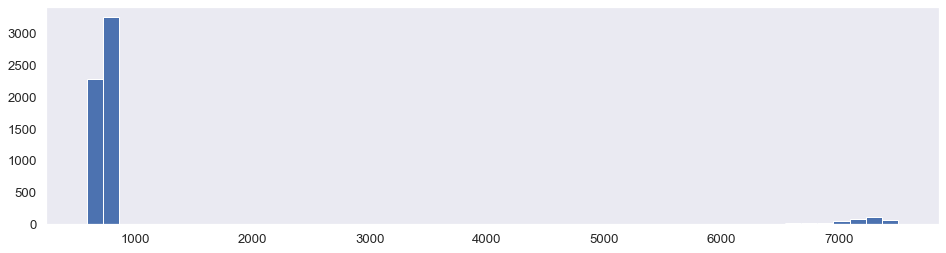

In [557]:
'''Вывод графика Credit Score без изменений'''
HIST(df_train[nc[4]], h=4)

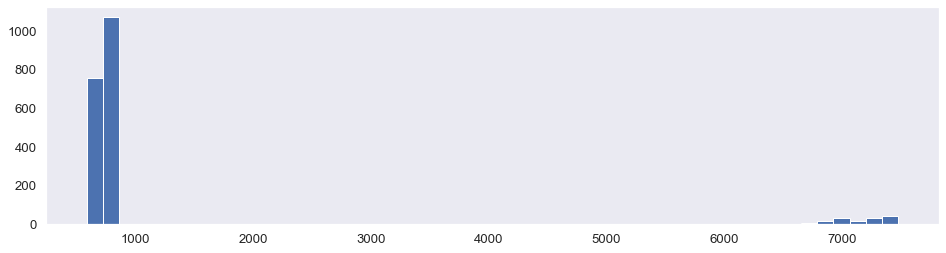

In [558]:
'''Вывод графика Credit Score без изменений'''
HIST(df_test[nc[4]], h=4)

In [559]:
'''Исключительно для проверки. Сохраним индексы примеров для значений больше 5000'''
ind_cred_scor = df_train.loc[df_train[nc[4]] > 5000, nc[4]].index
ind_cred_scor_test = df_test.loc[df_test[nc[4]] > 5000, nc[4]].index

In [560]:
df_train[nc[4]][ind_cred_scor]

69      6470.0
87      7440.0
94      7010.0
96      7320.0
116     7390.0
         ...  
7422    6690.0
7433    6060.0
7450    7290.0
7460    7470.0
7496    7410.0
Name: Credit Score, Length: 400, dtype: float64

In [561]:
'''Произведем замену значений, а именно делим на 10 всё что больше 5000'''
df_train.loc[df_train[nc[4]] > 5000, nc[4]] = df_train.loc[df_train[nc[4]] > 5000, nc[4]] / 10
df_test.loc[df_test[nc[4]] > 5000, nc[4]] = df_test.loc[df_test[nc[4]] > 5000, nc[4]] / 10
df_train[nc[4]][ind_cred_scor]

69      647.0
87      744.0
94      701.0
96      732.0
116     739.0
        ...  
7422    669.0
7433    606.0
7450    729.0
7460    747.0
7496    741.0
Name: Credit Score, Length: 400, dtype: float64

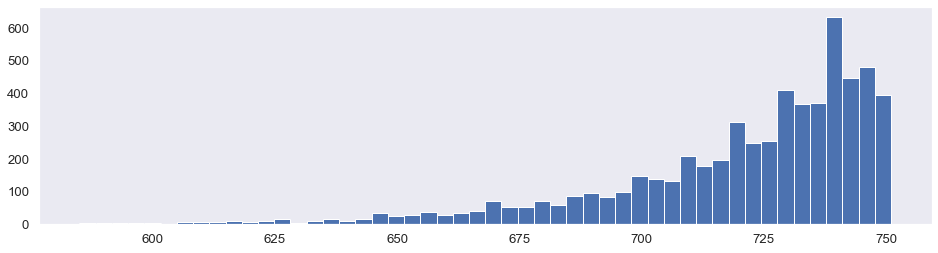

In [562]:
'''Вывод графика Credit Score с измененными значениями'''
HIST(df_train[nc[4]], h=4)

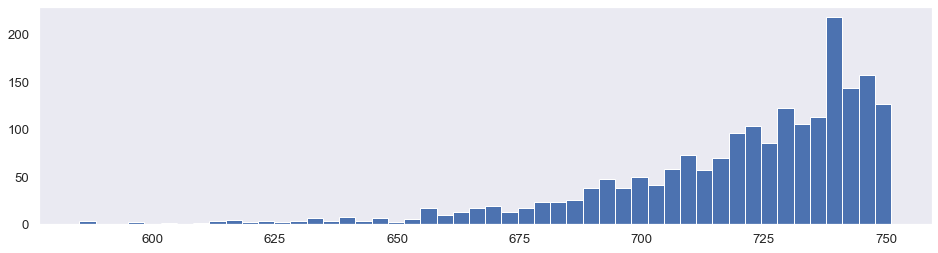

In [563]:
'''Вывод графика Credit Score с измененными значениями'''
HIST(df_test[nc[4]], h=4)

In [564]:
print(f'Доля пропущенных значений {round(df_train[nc[4]].isna().sum() / df_train[nc[4]].shape[0] * 100, 2)}%')

Доля пропущенных значений 20.76%


In [565]:
credit_score_model_train = build_model_nan(df_train, columns, nc[4])
credit_score_model_test = build_model_nan(df_test, columns, nc[4])

In [566]:
df_train.loc[df_train[nc[4]].isna(), nc[4]] = predict_model_nan(df_train, credit_score_model_train, columns, nc[4])
df_test.loc[df_test[nc[4]].isna(), nc[4]] = predict_model_nan(df_test, credit_score_model_test, columns, nc[4])

In [567]:
nc[3]

'Bankruptcies'

In [568]:
print(f'Доля пропущенных значений {round(df_train[nc[3]].isna().sum() / df_train[nc[3]].shape[0] * 100, 2)}%')

Доля пропущенных значений 0.19%


In [569]:
df_train.loc[df_train[nc[3]].isna(), nc[3]] = df_train[nc[3]].mode()[0]
df_test.loc[df_test[nc[3]].isna(), nc[3]] = df_test[nc[3]].mode()[0]

Контрольная проверка наличия пропусков в датасете

In [570]:
df_train.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [571]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

Пропусков не обнаружено

### 3. Обработка выбросов

Выбросы будем считать все данные за пределами доверительного интервала a = 0,05

In [572]:
objcol = Object_columns(df_train)

nancol_dict = Nan_columns(df_train)

nancol = list(nancol_dict.keys())

col = list(df_train.columns)

if nc or obj_col in col:
    del_list = set(nancol + objcol)
    for val in del_list:
        col.remove(val)

col.remove(target_name)
col

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

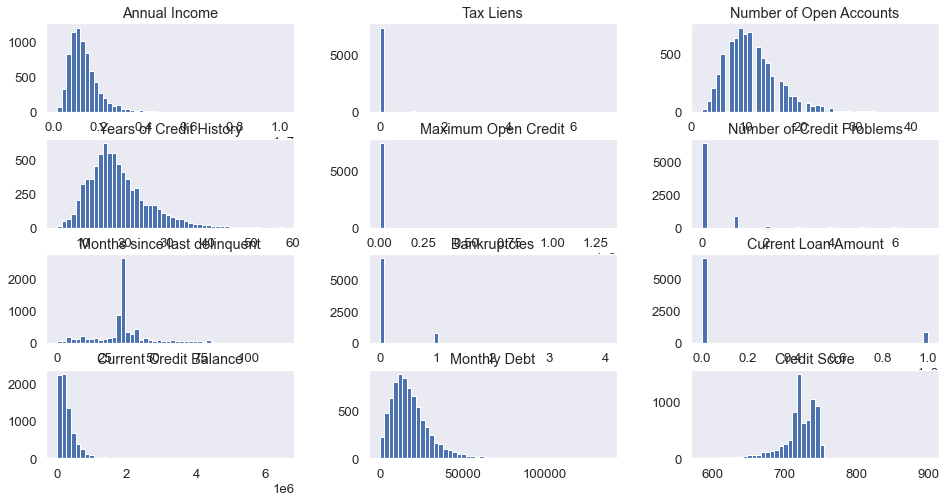

In [573]:
HIST(df_train[col])

Для графиков Maximum Open Credit и Current Loan Amount выполним дополнительную подготовку данных для обработки выбросов

Вывод гистограм значений по отдельности

In [574]:
col[4]

'Maximum Open Credit'

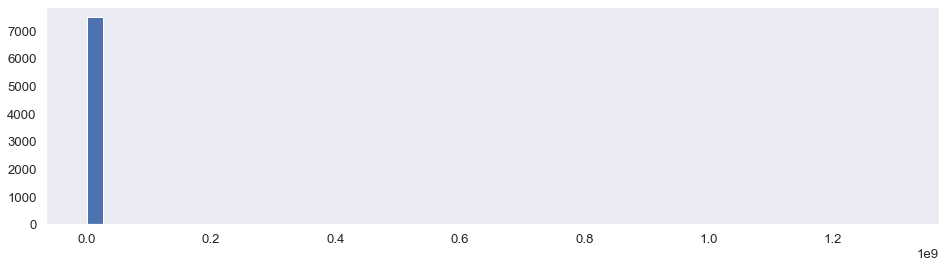

In [575]:
HIST(df_train[col[4]], h=4)

In [576]:
max_count, quant_99 = df_train[col[4]].max(), np.quantile(df_train[col[4]], q=0.99)
max_count, quant_99

(1304726170.0, 3568459.4000000106)

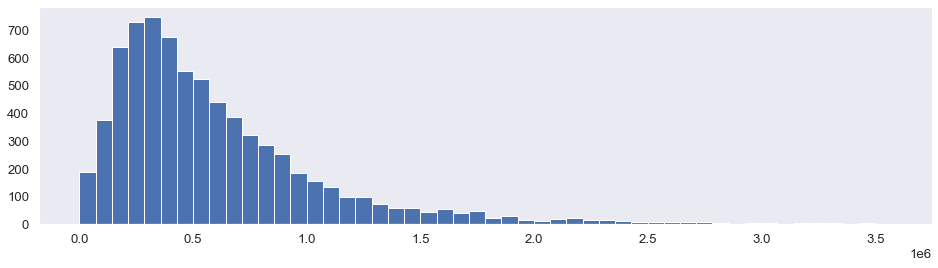

In [577]:
HIST(df_train.loc[(df_train[col[4]] < quant_99), col[4]], h=4)

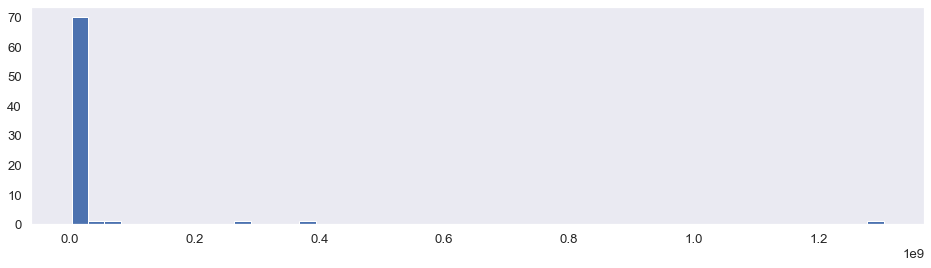

In [578]:
HIST(df_train.loc[(df_train[col[4]] > quant_99), col[4]], h=4)

In [579]:
change = df_train.loc[(df_train[col[4]] < quant_99), col[4]].mode()[0]
df_train.loc[(df_train[col[4]] > quant_99), col[4]] = change

In [580]:
change_test = df_test.loc[(df_test[col[4]] < quant_99), col[4]].mode()[0]
df_test.loc[(df_test[col[4]] > quant_99), col[4]] = change_test

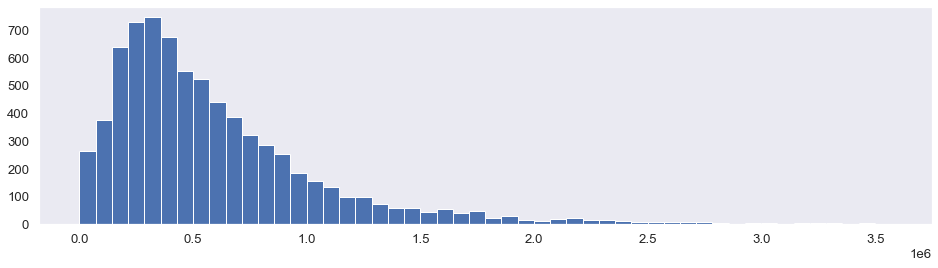

In [581]:
HIST(df_train[col[4]], h=4)

In [582]:
col[8]

'Current Loan Amount'

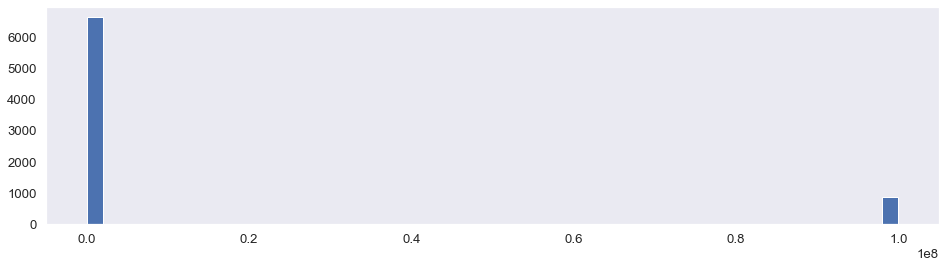

In [583]:
HIST(df_train[col[8]], h=4)

In [584]:
max_count, quant_99 = df_train[col[8]].max(), np.quantile(df_train[col[8]], q=0.99)
max_count, quant_99

(99999999.0, 99999999.0)

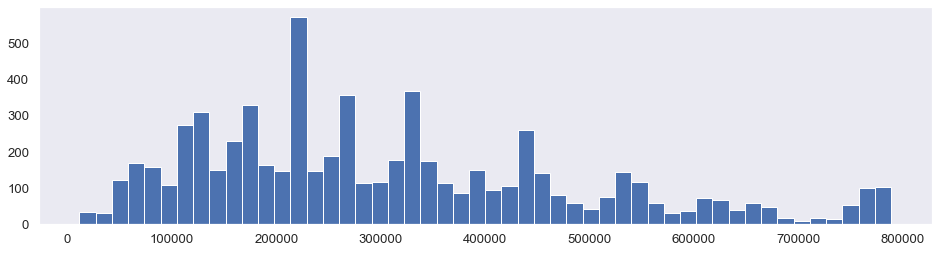

In [585]:
HIST(df_train.loc[(df_train[col[8]] < quant_99), col[8]], h=4)

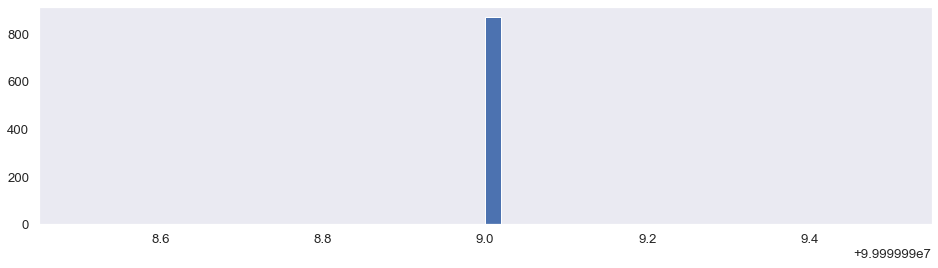

In [586]:
HIST(df_train.loc[(df_train[col[8]] > quant_99-1), col[8]], h=4)

Наблюдается большое количество значений для действующей суммы кредита за пределами интервала a=0.99

In [587]:
current_loan_amount_mode = df_train.loc[(df_train[col[8]] < quant_99), col[8]].mode()[0]

In [588]:
df_train.loc[(df_train[col[8]] > quant_99-1), col[8]] = current_loan_amount_mode

In [589]:
current_loan_amount_mode_test = df_test.loc[(df_test[col[8]] < quant_99), col[8]].mode()[0]

In [590]:
df_test.loc[(df_test[col[8]] > quant_99-1), col[8]] = current_loan_amount_mode_test

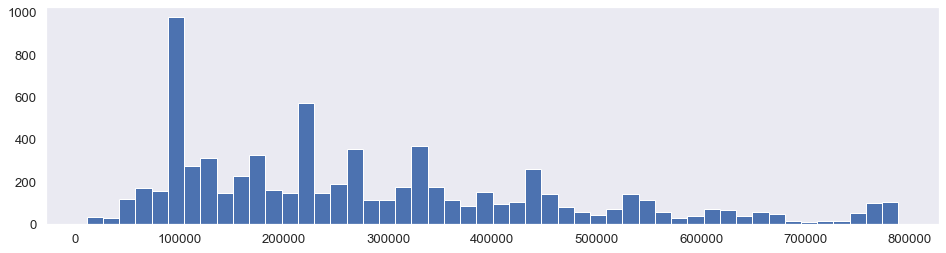

In [591]:
HIST(df_train[col[8]], h=4)

In [592]:
df_train = clear_data(df_train, col, q_min=0.05, q_max=0.95)

Annual Income
Доля выбросов в процентах 10.0%

Tax Liens
Доля выбросов в процентах 1.79%

Number of Open Accounts
Доля выбросов в процентах 9.21%

Years of Credit History
Доля выбросов в процентах 9.57%

Maximum Open Credit
Доля выбросов в процентах 10.0%

Number of Credit Problems
Доля выбросов в процентах 1.99%

Months since last delinquent
Доля выбросов в процентах 8.92%

Bankruptcies
Доля выбросов в процентах 0.53%

Current Loan Amount
Доля выбросов в процентах 9.99%

Current Credit Balance
Доля выбросов в процентах 10.0%

Monthly Debt
Доля выбросов в процентах 9.99%

Credit Score
Доля выбросов в процентах 7.96%



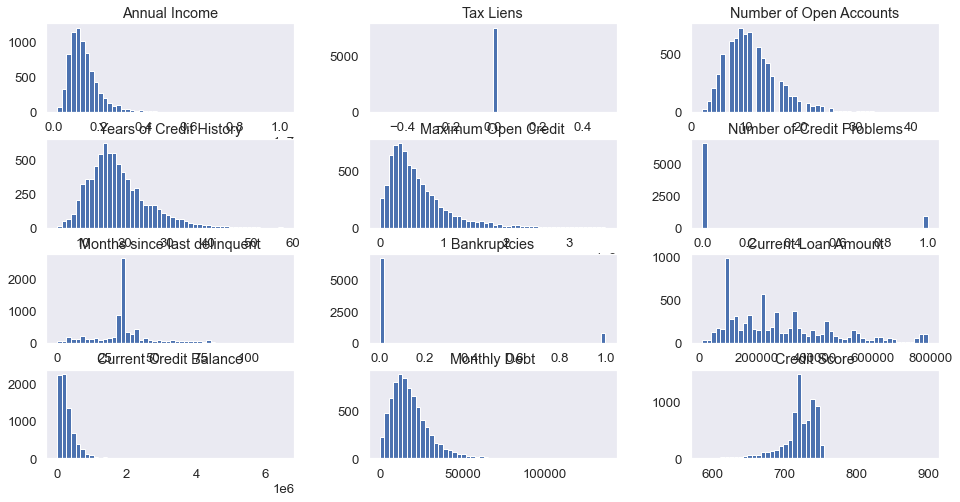

In [593]:
HIST(df_train[col])

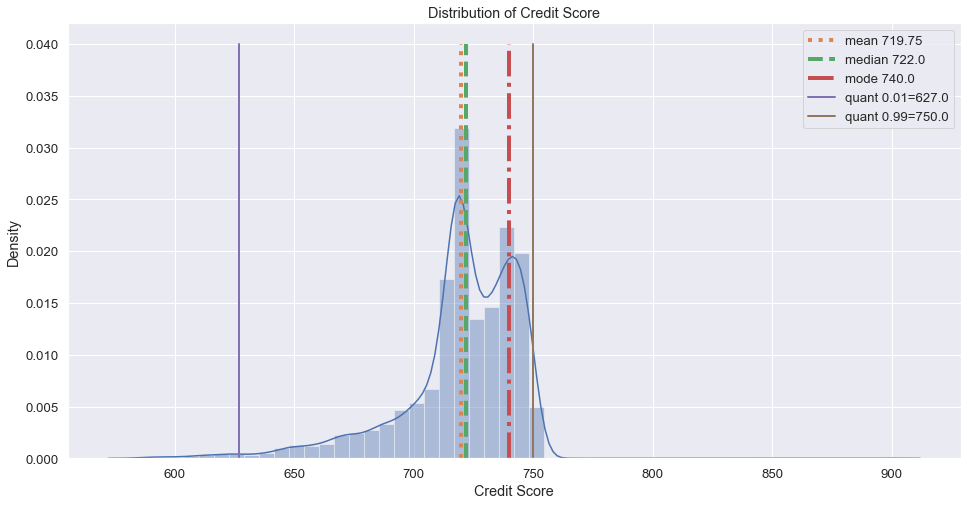

In [594]:
Mean_Median_Mode(df_train[col[-1]], divisor=0.04)

In [595]:
df_train.loc[(df_train[col[-1]] > 760), col[-1]] = 740

In [596]:
df_test = clear_data(df_test, col, q_min=0.025, q_max=0.975)

Annual Income
Доля выбросов в процентах 5.04%

Tax Liens
Доля выбросов в процентах 2.2%

Number of Open Accounts
Доля выбросов в процентах 4.0%

Years of Credit History
Доля выбросов в процентах 4.92%

Maximum Open Credit
Доля выбросов в процентах 5.04%

Number of Credit Problems
Доля выбросов в процентах 1.72%

Months since last delinquent
Доля выбросов в процентах 4.84%

Bankruptcies
Доля выбросов в процентах 0.44%

Current Loan Amount
Доля выбросов в процентах 5.0%

Current Credit Balance
Доля выбросов в процентах 5.04%

Monthly Debt
Доля выбросов в процентах 5.04%

Credit Score
Доля выбросов в процентах 4.68%



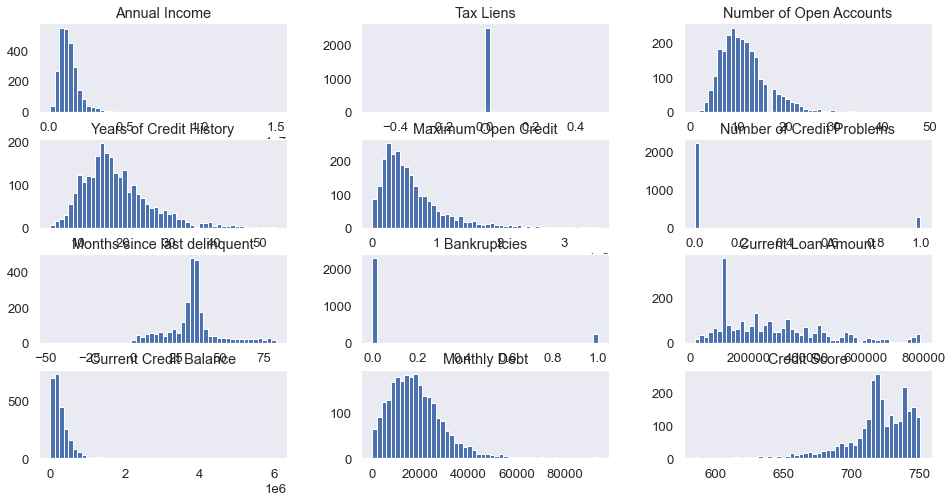

In [597]:
HIST(df_test[col])

### 4. Кодирование признаков типа object

Список признаков

In [598]:
obj_col

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [599]:
df_train.insert(0, 'ID', df_train.index.tolist())

In [600]:
df_test.insert(0, 'ID', df_test.index.tolist())

In [601]:
obj_col[3]

'Term'

In [602]:
df_train['Is_Term'] = df_train[obj_col[3]].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
df_test['Is_Term'] = df_test[obj_col[3]].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [603]:
obj_col[1]

'Years in current job'

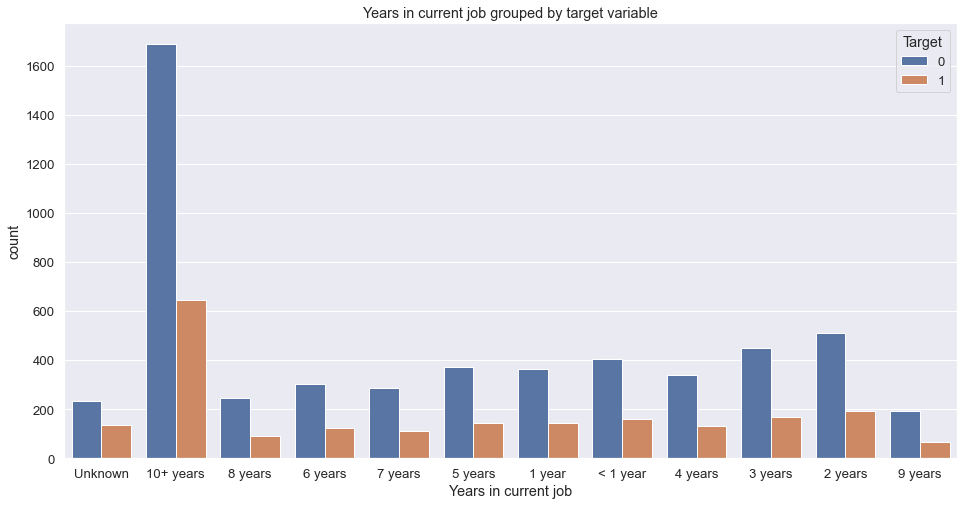

In [604]:
count_info_hist(df_train, obj_col[1], target_name, h=8)

In [605]:
df_train[obj_col[1]].unique()

array(['Unknown', '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [606]:
df_train['Years_in_curent_job_new'] = df_train[obj_col[1]].map({'Unknown':'-1',
                                                                '< 1 year':'0',
                                                                '1 year':'1', 
                                                                '2 years':'2',
                                                                '3 years':'3',
                                                                '4 years':'4',
                                                                '5 years':'5',
                                                                '6 years':'6',
                                                                '7 years':'7',
                                                                '8 years':'8',
                                                                '9 years':'9',
                                                                '10+ years':'10'}).astype(int)

In [607]:
df_test['Years_in_curent_job_new'] = df_test[obj_col[1]].map({'Unknown':'-1',
                                                                '< 1 year':'0',
                                                                '1 year':'1', 
                                                                '2 years':'2',
                                                                '3 years':'3',
                                                                '4 years':'4',
                                                                '5 years':'5',
                                                                '6 years':'6',
                                                                '7 years':'7',
                                                                '8 years':'8',
                                                                '9 years':'9',
                                                                '10+ years':'10'}).astype(int)

In [608]:
obj_col[0]

'Home Ownership'

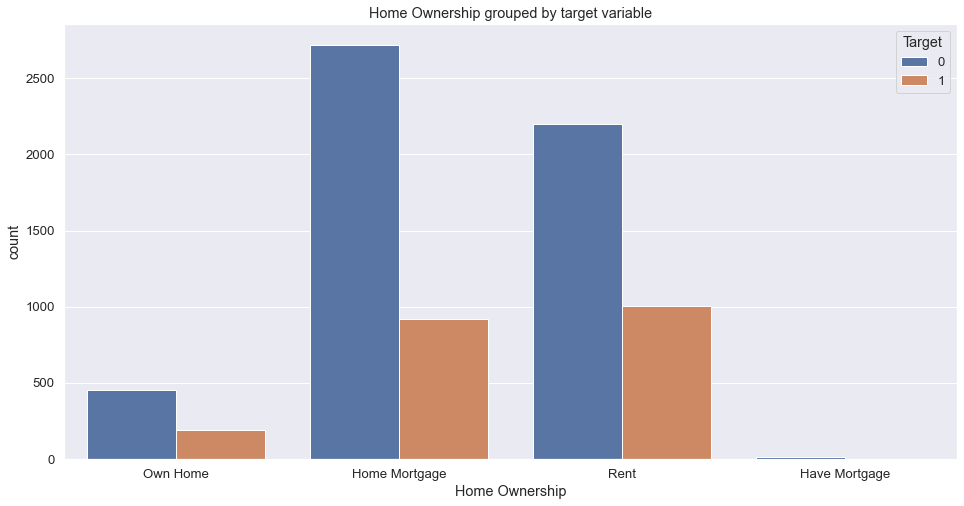

In [609]:
count_info_hist(df_train, obj_col[0], target_name, h=8)

In [610]:
home_df, home_style = assessing_impact_on_target(df_train, obj_col[0], target_name)
home_df

,Own Home,Home Mortgage,Rent,Have Mortgage
Own Home,0,-1,1,1
Home Mortgage,-1,0,-1,1
Rent,1,-1,0,1
Have Mortgage,1,1,1,0


In [611]:
qwe = feature_for_join(home_style, 1)
qwe

['Own Home', 'Rent', 'Have Mortgage']

In [612]:
df_train['Is_Home_Ownership'] = df_train['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

In [613]:
df_test['Is_Home_Ownership'] = df_test['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

In [614]:
obj_col[2]

'Purpose'

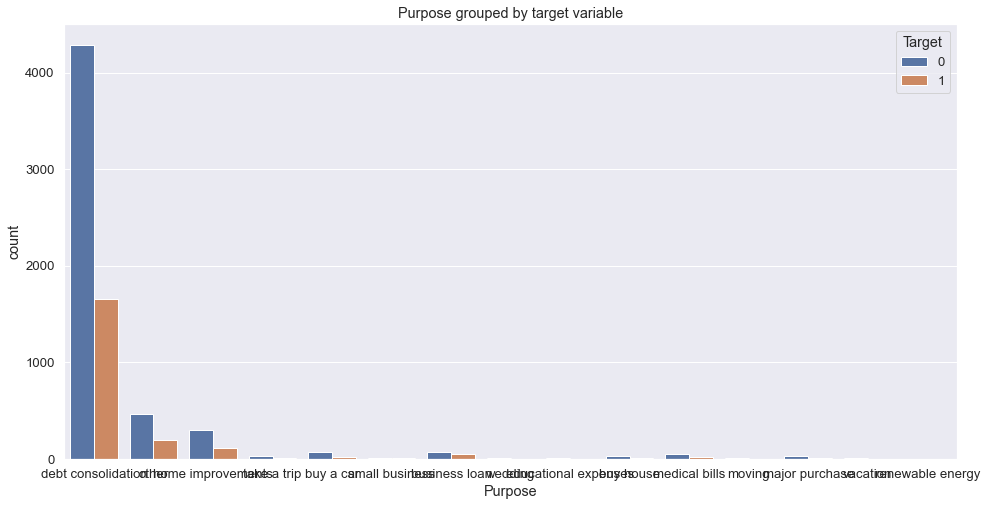

In [615]:
count_info_hist(df_train, obj_col[2], target_name, h=8)

In [616]:
purpose_style, purpose_df = assessing_impact_on_target(df_train, obj_col[2], target_name)
purpose_style

,debt consolidation,other,home improvements,take a trip,buy a car,small business,business loan,wedding,educational expenses,buy house,medical bills,moving,major purchase,vacation,renewable energy
debt consolidation,0,1,1,1,1,-1,-1,1,1,1,1,1,1,1,-1
other,1,0,1,1,1,-1,-1,1,1,1,1,1,1,1,-1
home improvements,1,1,0,1,1,-1,-1,1,1,1,1,1,1,1,-1
take a trip,1,1,1,0,1,-1,1,1,1,1,1,1,1,1,-1
buy a car,1,1,1,1,0,-1,-1,1,1,1,1,1,1,1,-1
small business,-1,-1,-1,-1,-1,0,1,1,-1,-1,-1,-1,-1,1,-1
business loan,-1,-1,-1,1,-1,1,0,1,-1,1,1,1,-1,1,-1
wedding,1,1,1,1,1,1,1,0,1,1,1,1,1,1,-1
educational expenses,1,1,1,1,1,-1,-1,1,0,1,1,1,1,1,-1
buy house,1,1,1,1,1,-1,1,1,1,0,1,1,1,1,-1


In [617]:
feature_purpose_df = feature_for_join(purpose_df, 3)
feature_purpose_df

['debt consolidation',
 'other',
 'home improvements',
 'take a trip',
 'buy a car',
 'wedding',
 'educational expenses',
 'buy house',
 'medical bills',
 'moving',
 'major purchase',
 'vacation']

In [618]:
df_train['Is_Purpose'] = df_train['Purpose'].map({'debt consolidation':'other',
                                                  'other':'other',
                                                  'home improvements':'other',
                                                  'take a trip':'other',
                                                  'buy a car':'other',
                                                  'small business':'small business',
                                                  'business loan':'business loan',
                                                  'wedding':'other',
                                                  'educational expenses':'other',
                                                  'buy house':'other',
                                                  'medical bills':'other',
                                                  'moving':'other',
                                                  'major purchase':'other',
                                                  'vacation':'other',
                                                  'renewable energy':'renewable energy'})

In [619]:
df_test['Is_Purpose'] = df_test['Purpose'].map({'debt consolidation':'other',
                                                'other':'other',
                                                'home improvements':'other',
                                                'take a trip':'other',
                                                'buy a car':'other',
                                                'small business':'small business',
                                                'business loan':'business loan',
                                                'wedding':'other',
                                                'educational expenses':'other',
                                                'buy house':'other',
                                                'medical bills':'other',
                                                'moving':'other',
                                                'major purchase':'other',
                                                'vacation':'other',
                                                'renewable energy':'renewable energy'})

In [620]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Is_Purpose'], prefix='Is_Purpose')], axis=1)

In [621]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Is_Purpose'], prefix='Is_Purpose')], axis=1)

In [622]:
df_train.head(10)

,ID,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,...,Credit Score,Credit Default,Is_Term,Years_in_curent_job_new,Is_Home_Ownership,Is_Purpose,Is_Purpose_business loan,Is_Purpose_other,Is_Purpose_renewable energy,Is_Purpose_small business
0,0,Own Home,4.820870e+05,Unknown,0.0,11.0,26.3,6.859600e+05,1.0,40.822994,...,749.000000,0,0,-1,0,other,0,1,0,0
1,1,Own Home,1.025487e+06,10+ years,0.0,15.0,15.3,1.181730e+06,0.0,33.743650,...,737.000000,1,1,10,0,other,0,1,0,0
2,2,Home Mortgage,7.514120e+05,8 years,0.0,11.0,35.0,1.182434e+06,0.0,33.189881,...,742.000000,0,0,8,1,other,0,1,0,0
3,3,Own Home,8.050680e+05,6 years,0.0,8.0,22.5,1.474000e+05,1.0,41.009482,...,694.000000,0,0,6,0,other,0,1,0,0
4,4,Rent,7.762640e+05,8 years,0.0,13.0,13.6,3.858360e+05,1.0,41.567814,...,719.000000,0,0,8,0,other,0,1,0,0
5,5,Rent,1.286280e+06,7 years,0.0,12.0,14.6,3.667840e+05,0.0,33.598729,...,717.493354,1,1,7,0,other,0,1,0,0
6,6,Home Mortgage,1.511108e+06,10+ years,0.0,9.0,20.3,3.881240e+05,0.0,73.000000,...,745.000000,0,0,10,1,other,0,1,0,0
7,7,Rent,1.040060e+06,10+ years,0.0,13.0,12.0,3.303740e+05,0.0,18.000000,...,705.000000,1,0,10,0,other,0,1,0,0
8,8,Home Mortgage,4.033530e+05,5 years,0.0,17.0,15.7,2.552255e-10,1.0,41.713924,...,716.490473,0,0,5,1,other,0,1,0,0
9,9,Home Mortgage,1.371679e+06,1 year,0.0,10.0,24.6,5.113020e+05,0.0,6.000000,...,721.488488,1,1,1,1,other,0,1,0,0


### 5. Анализ данных

In [623]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [624]:
BASE_FEATURE_NAMES.remove('Tax Liens')

In [625]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [626]:
NEW_FEATURE_NAMES

Index(['ID', 'Is_Term', 'Years_in_curent_job_new', 'Is_Home_Ownership',
       'Is_Purpose', 'Is_Purpose_business loan', 'Is_Purpose_other',
       'Is_Purpose_renewable energy', 'Is_Purpose_small business'],
      dtype='object')

Обзор целевой переменной

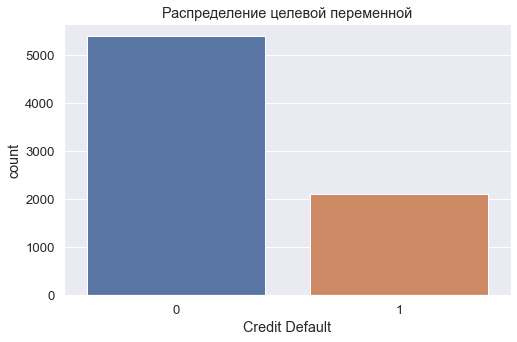

In [627]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title('Распределение целевой переменной')
plt.show()

Корреляция с базовыми признаками

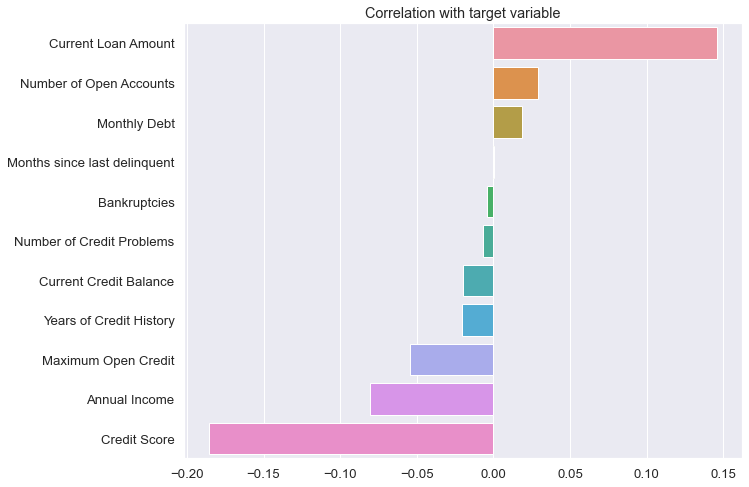

In [628]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

__Оценка признака «Annual Income» в разрезе целевой переменной__

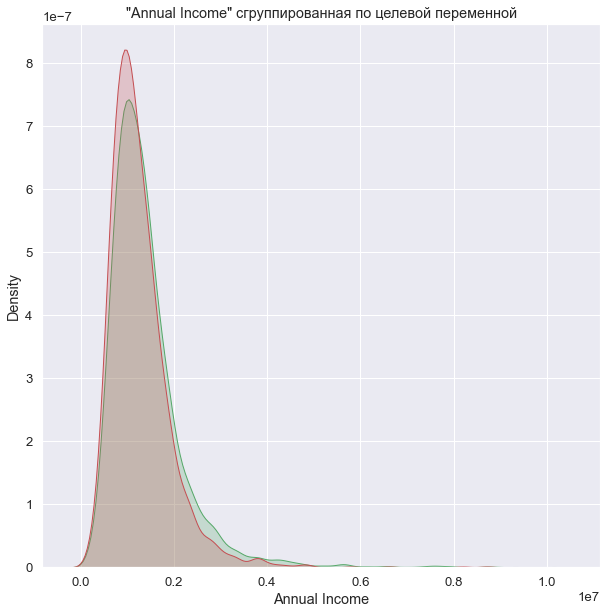

Показатель «Annual Income» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


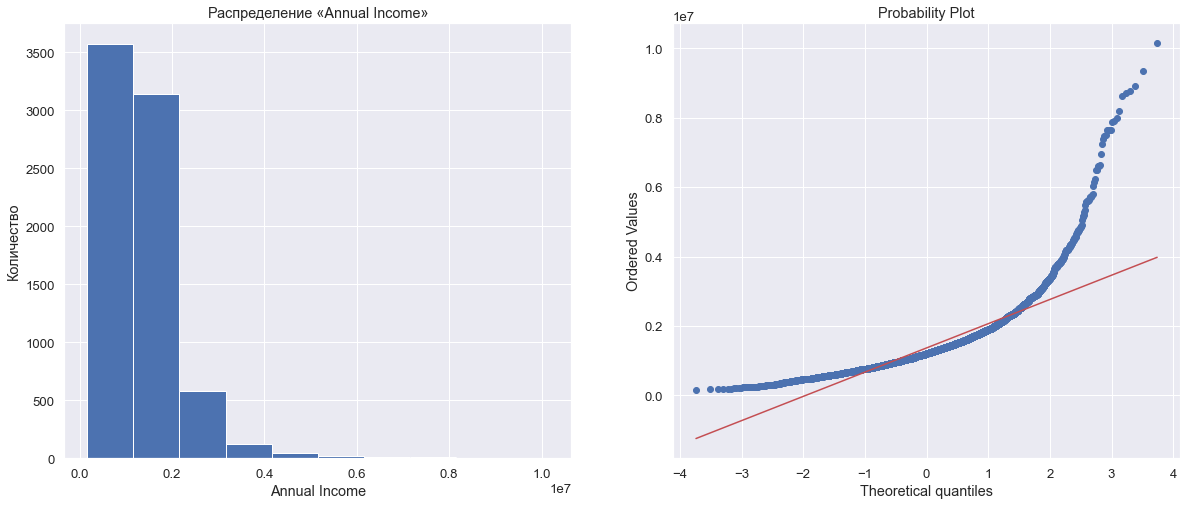

По показателю «Annual Income» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


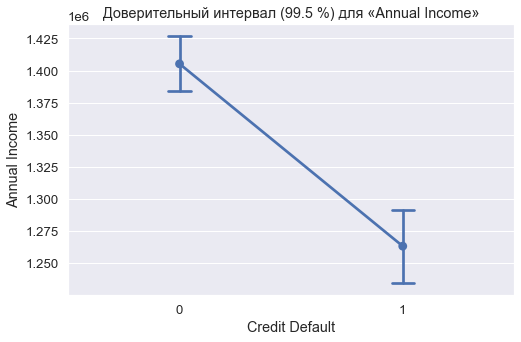

__Оценка признака «Number of Open Accounts» в разрезе целевой переменной__

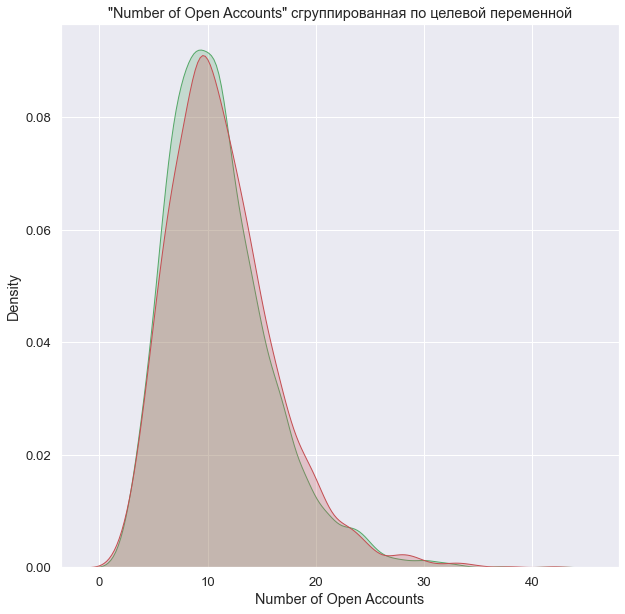

Показатель «Number of Open Accounts» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


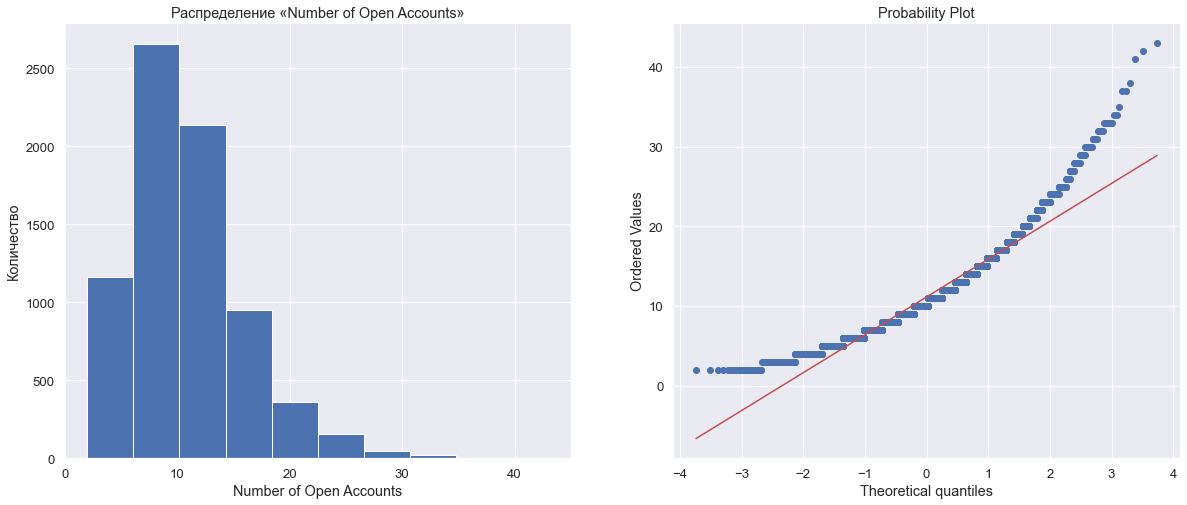

По показателю «Number of Open Accounts» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


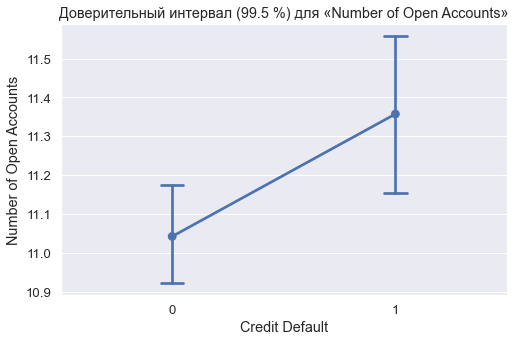

__Оценка признака «Years of Credit History» в разрезе целевой переменной__

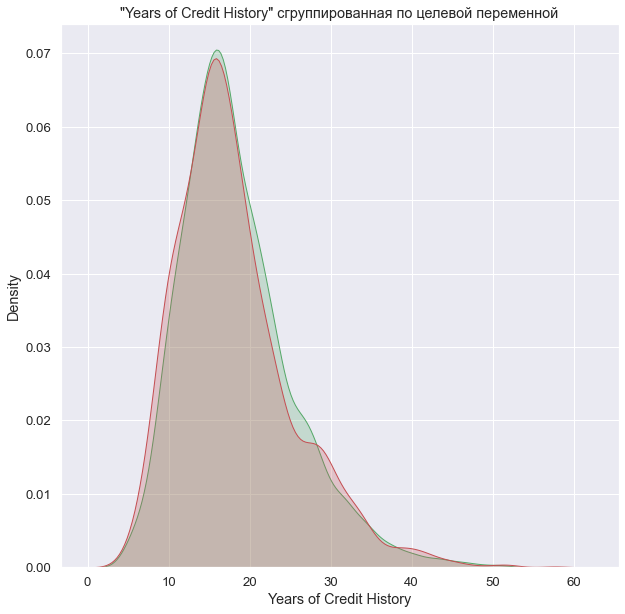

Показатель «Years of Credit History» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


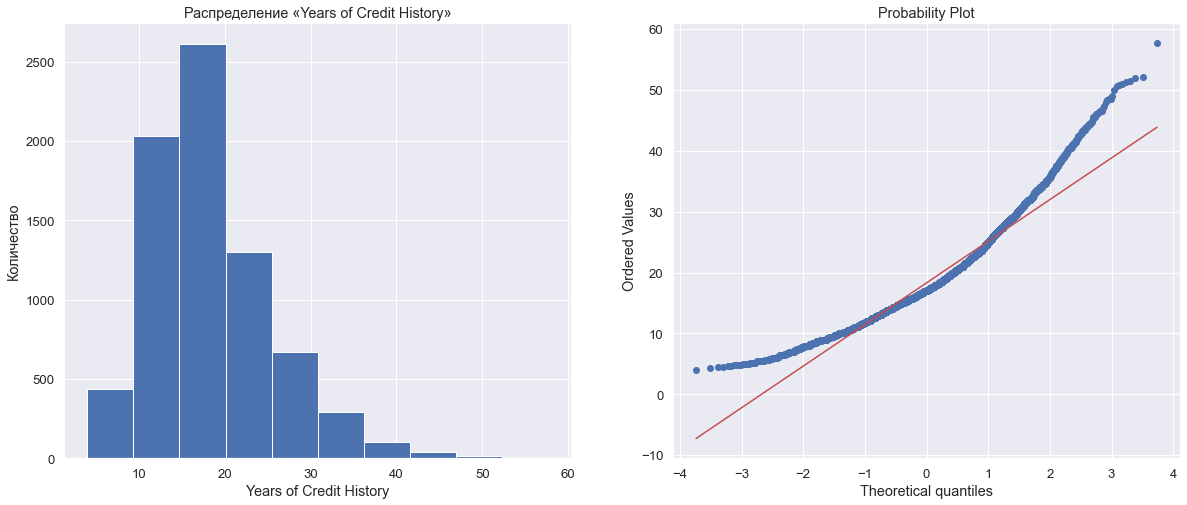

По показателю «Years of Credit History» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


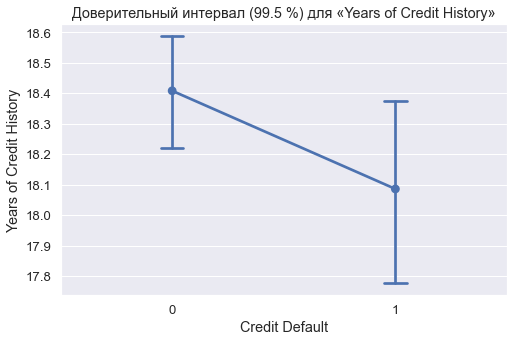

__Оценка признака «Maximum Open Credit» в разрезе целевой переменной__

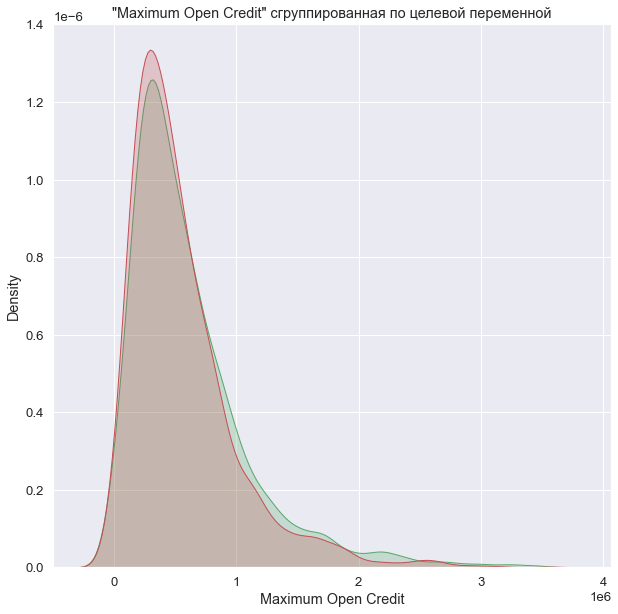

Показатель «Maximum Open Credit» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


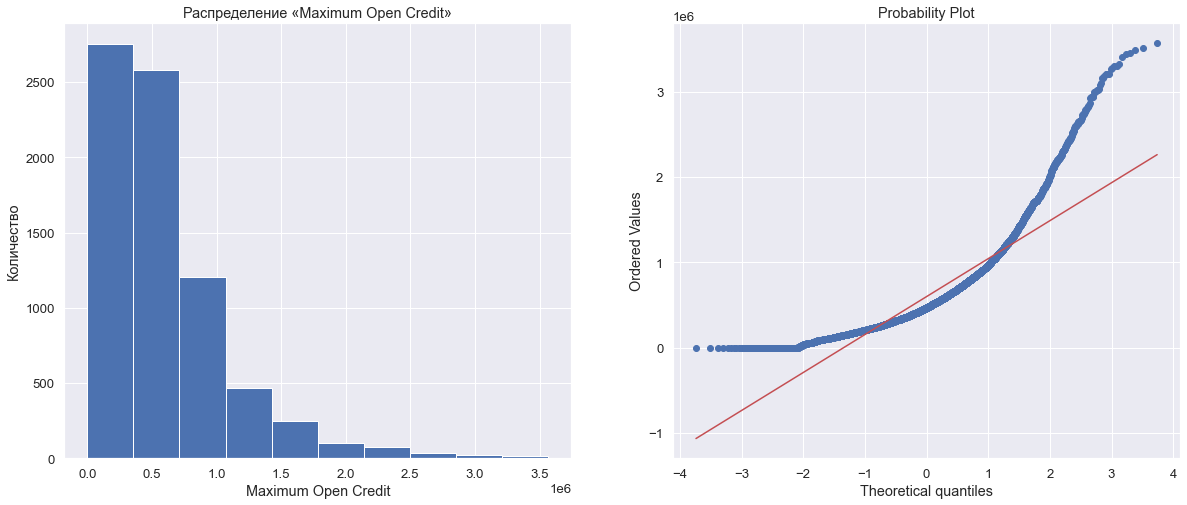

По показателю «Maximum Open Credit» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


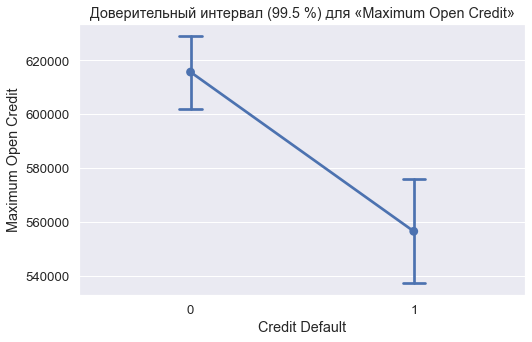

__Оценка признака «Number of Credit Problems» в разрезе целевой переменной__

Показатель «Number of Credit Problems» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


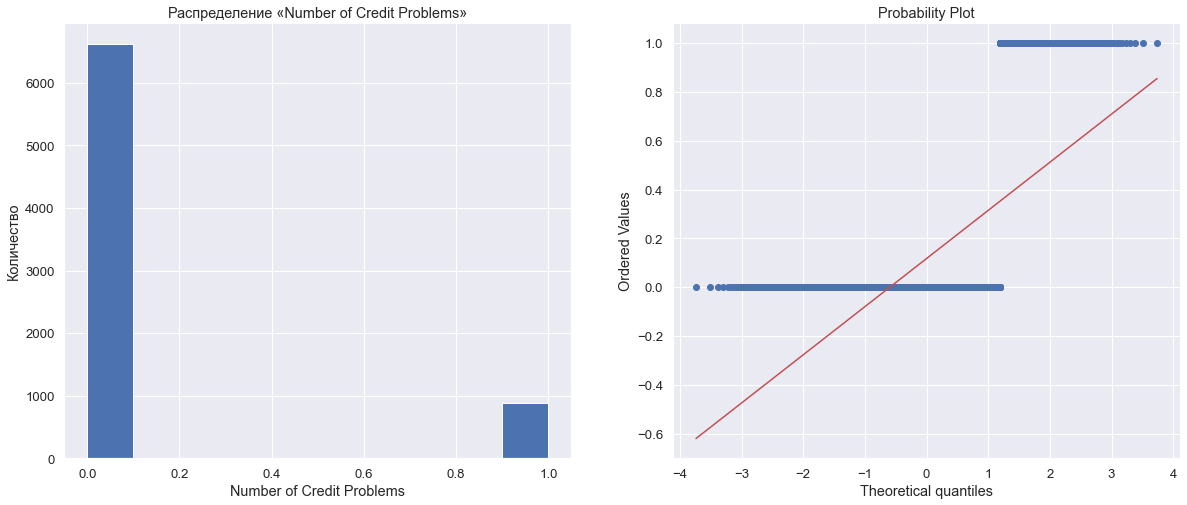

По показателю «Number of Credit Problems» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


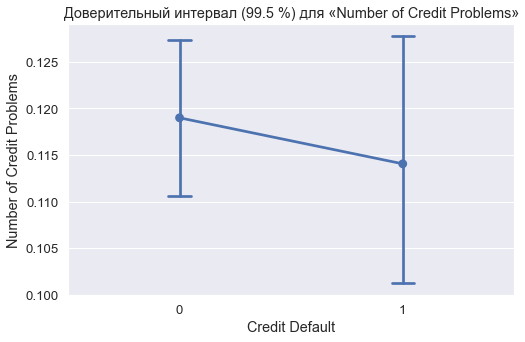

__Оценка признака «Months since last delinquent» в разрезе целевой переменной__

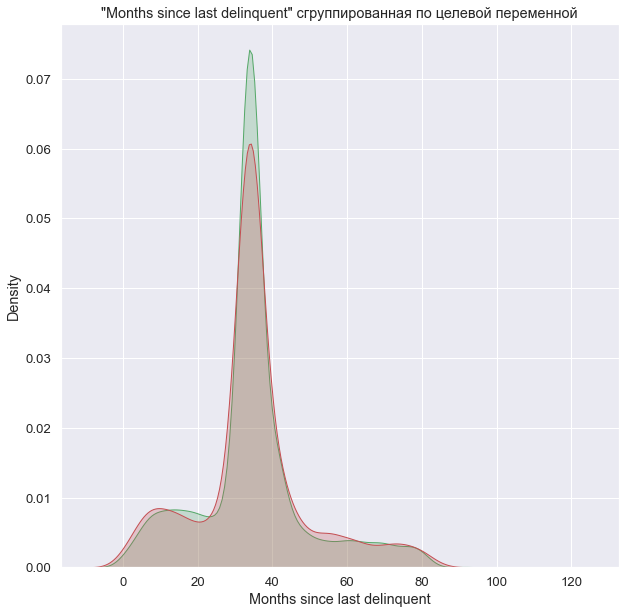

Показатель «Months since last delinquent» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


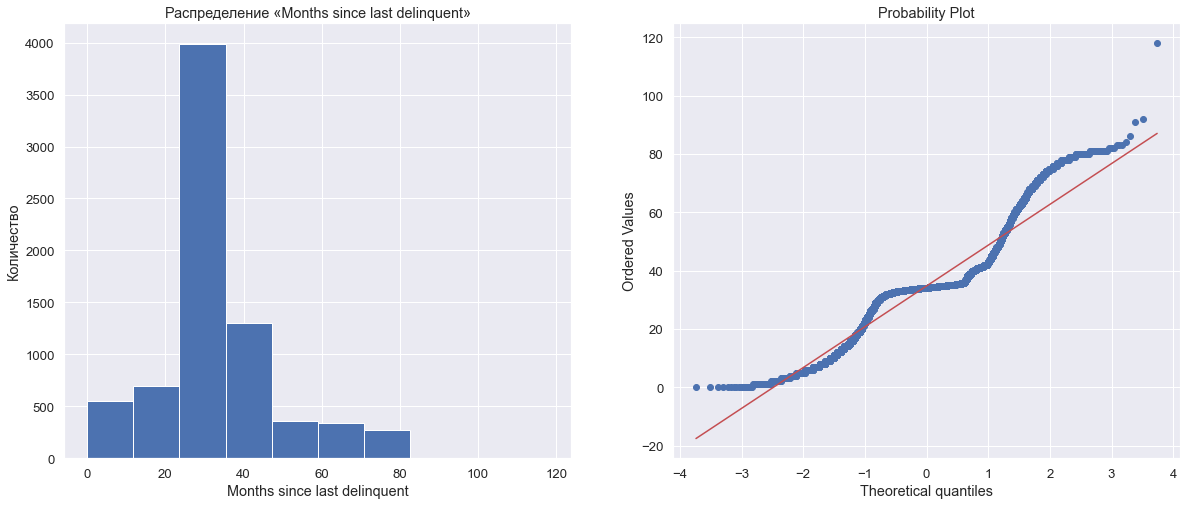

По показателю «Months since last delinquent» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


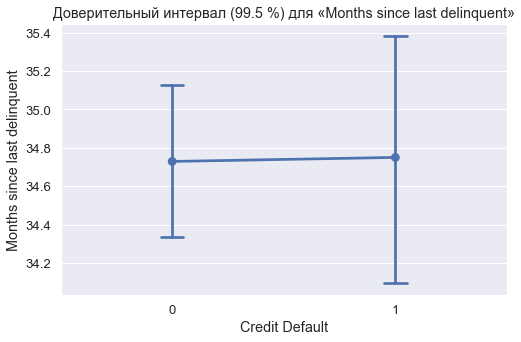

__Оценка признака «Bankruptcies» в разрезе целевой переменной__

Показатель «Bankruptcies» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


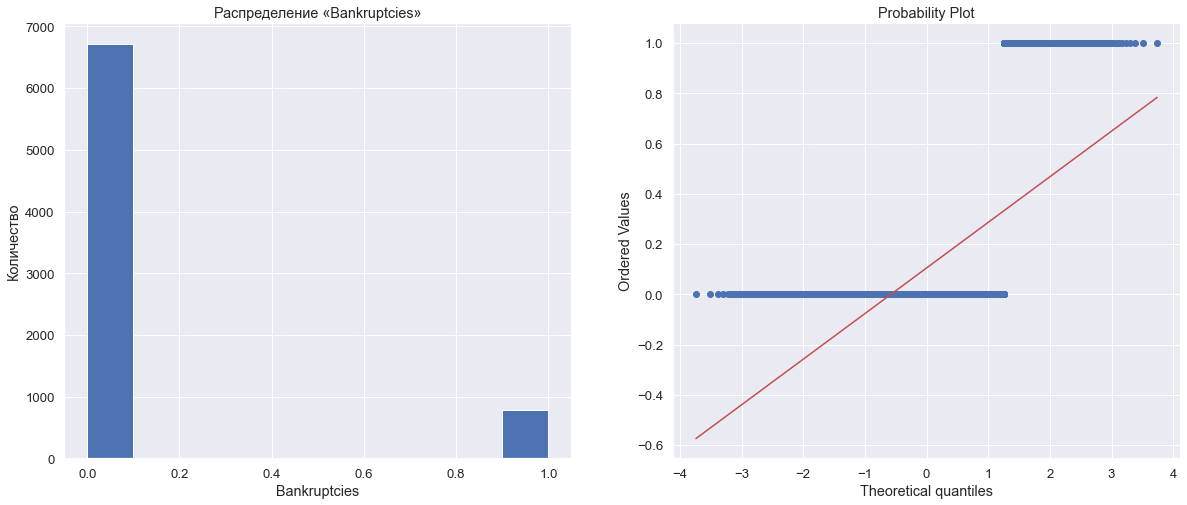

По показателю «Bankruptcies» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


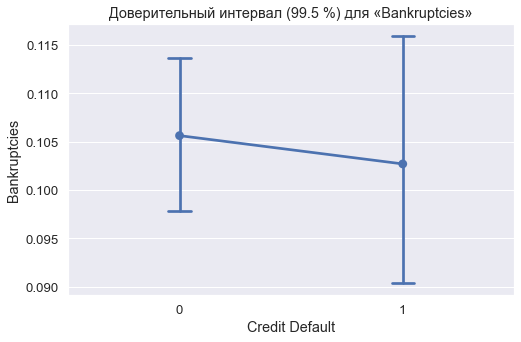

__Оценка признака «Current Loan Amount» в разрезе целевой переменной__

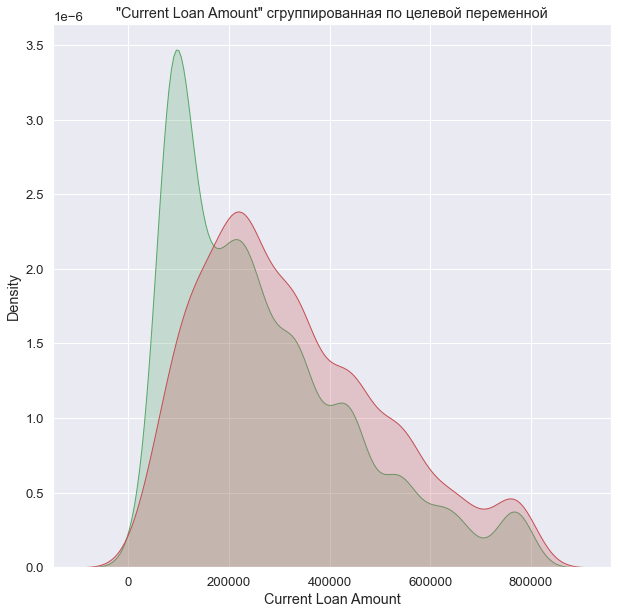

Показатель «Current Loan Amount» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


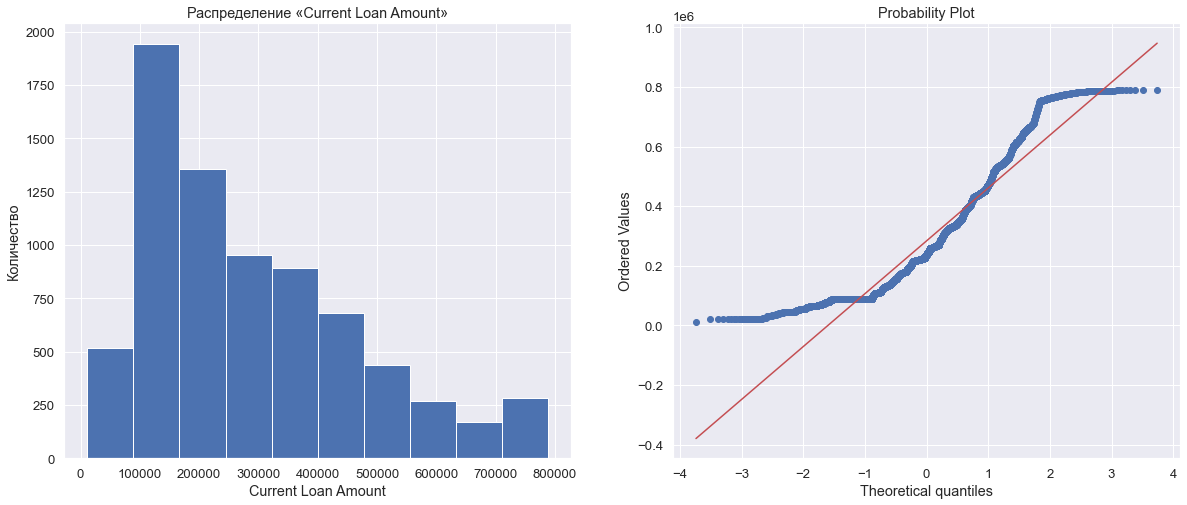

По показателю «Current Loan Amount» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


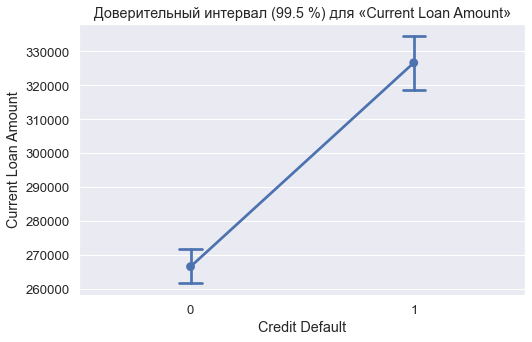

__Оценка признака «Current Credit Balance» в разрезе целевой переменной__

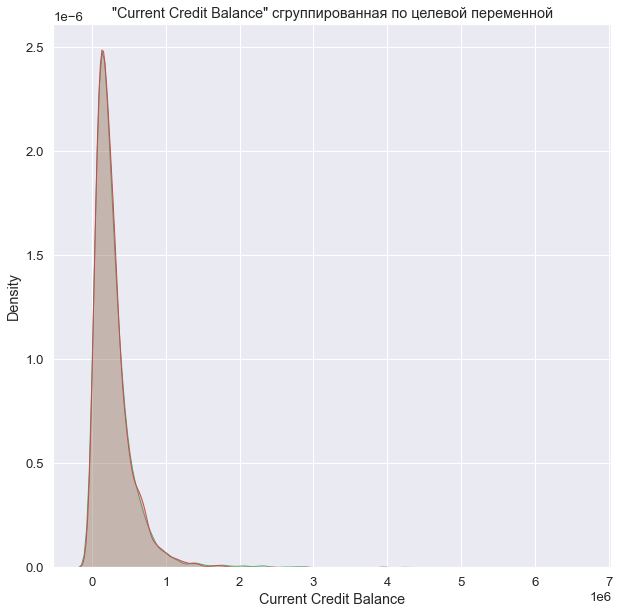

Показатель «Current Credit Balance» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


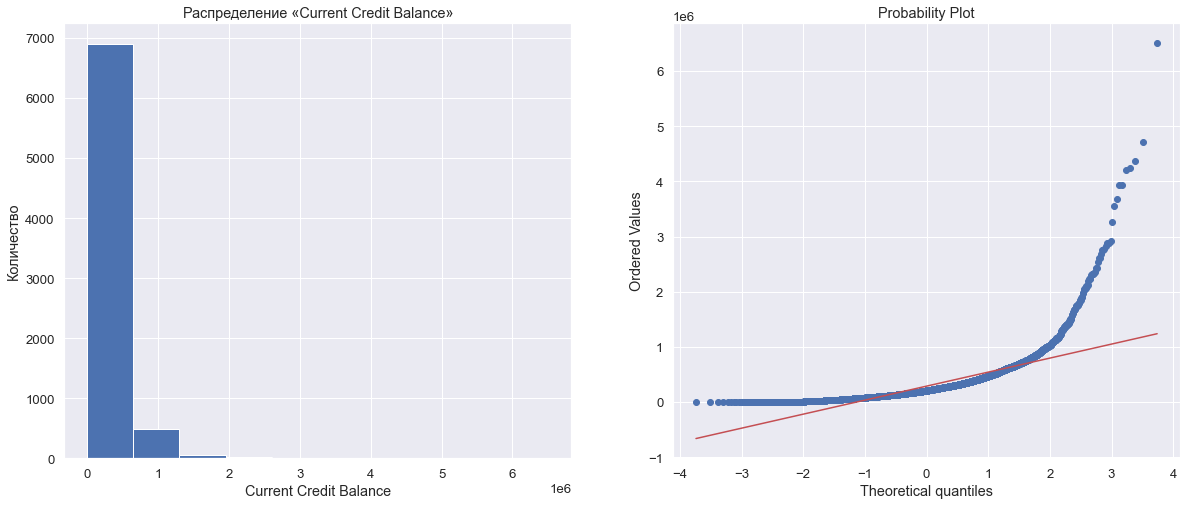

По показателю «Current Credit Balance» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


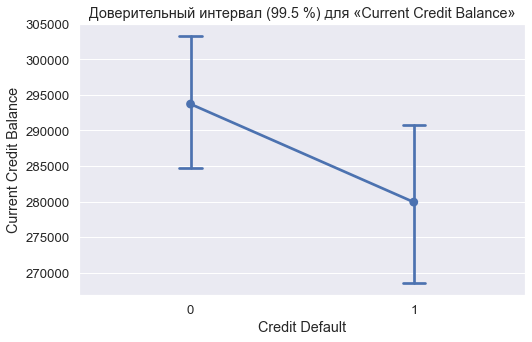

__Оценка признака «Monthly Debt» в разрезе целевой переменной__

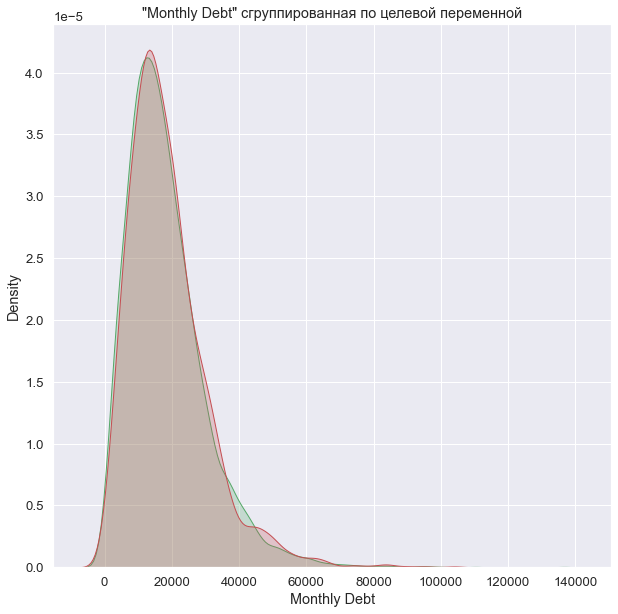

Показатель «Monthly Debt» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


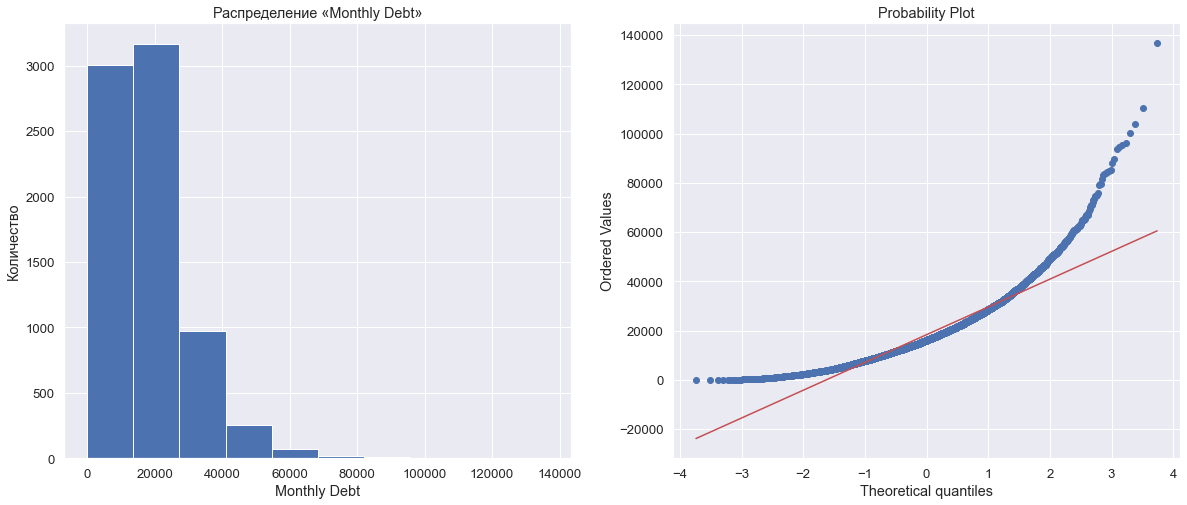

По показателю «Monthly Debt» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


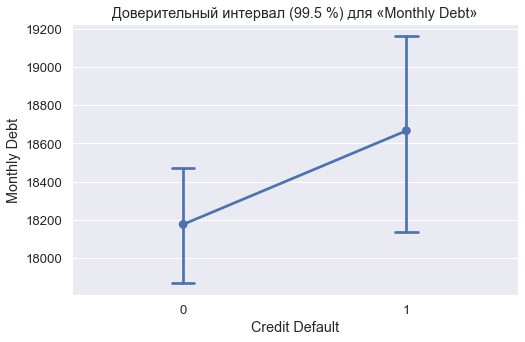

__Оценка признака «Credit Score» в разрезе целевой переменной__

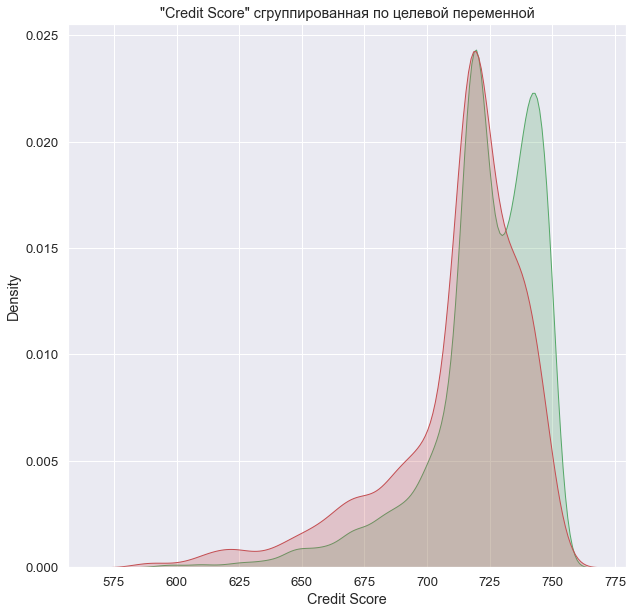

Показатель «Credit Score» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


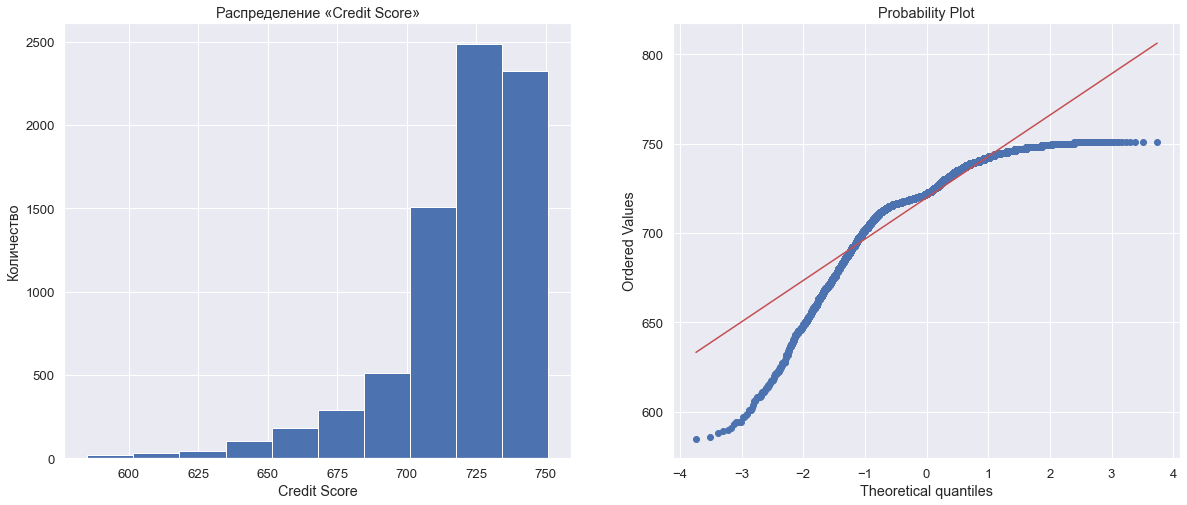

По показателю «Credit Score» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


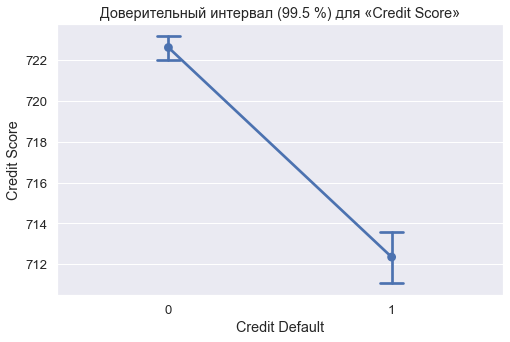

In [629]:
for cat_colname in df_train[BASE_FEATURE_NAMES].select_dtypes(include=['float64'], exclude=['object']).columns:
        if 'Tax Liens' == cat_colname or 'Number of Credit Problems' == cat_colname or 'Bankruptcies' == cat_colname:
            check_rate(df_train, TARGET_NAME, cat_colname, False)
        else:
            check_rate(df_train, TARGET_NAME, cat_colname)



По итогам анализа

Следующие показатели необходимо нормализовать логарифмированием:

    Maximum Open Credit
    Months since last delinquent

Следующие показатели не влияют на целевую переменную, поэтому от них можем избавиться:

    Months since last delinquent
    Bankruptcies
    Tax Liens

Слудующие показатели очень хорошо влияют на целевую переменную:

    Annual Income
    Maximum Open Credit
    Current Loan Amount
    Credit Score

Следующие показатели менее существенно влияют на целевую переменную:

    Number of Open Accounts
    Years of Credit History
    Number of Credit Problems
    Current Credit Balance
    Monthly Debt



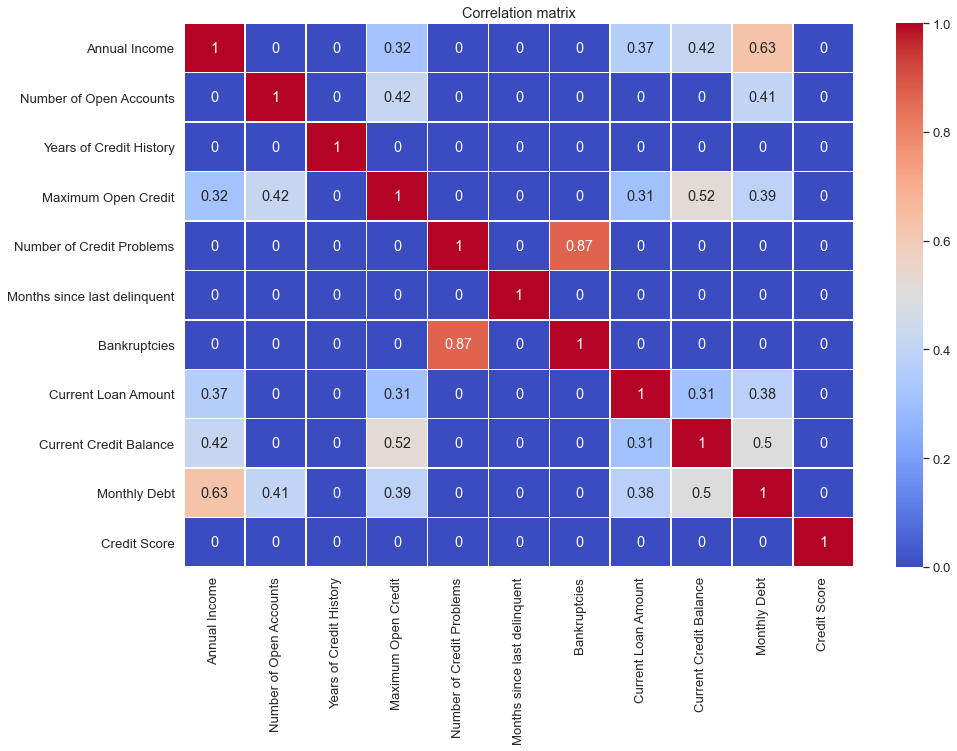

In [630]:
Cross_Vall(df_train[BASE_FEATURE_NAMES])

### 6. Отбор признаков

In [631]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Maximum Open Credit',
                     'Current Loan Amount',
                     'Credit Score',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Number of Credit Problems',
                     'Current Credit Balance',
                     'Monthly Debt',
                    'Years_in_curent_job_new']

In [632]:
CAT_FEATURE_NAMES = ['Is_Term',
                     'Is_Home_Ownership',
                     'Is_Purpose_business loan',
                     'Is_Purpose_other',
                     'Is_Purpose_small business']

In [633]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

In [634]:
SELECTED_FEATURE_NAMES

['Annual Income',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Credit Score',
 'Number of Open Accounts',
 'Years of Credit History',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Monthly Debt',
 'Years_in_curent_job_new',
 'Is_Term',
 'Is_Home_Ownership',
 'Is_Purpose_business loan',
 'Is_Purpose_other',
 'Is_Purpose_small business']

In [635]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

In [636]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_test_norm[NUM_FEATURE_NAMES])

df_test = df_test_norm.copy()

Сохранение модели

In [637]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

Разбиение на train и test

In [638]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### 7. Балансировка целевой переменной

In [639]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [640]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

Сохранение обучающего и тестового датасетов

In [641]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [642]:
TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_b.csv'
TEST_PART_PATH = 'course_project_test_part.csv'

SCALER_FILE_PATH = 'course_scaler.pkl'
MODEL_FILE_PATH = 'course_model.pkl'

RESULT_FILE_PATH = 'APosmitnyj_predictions.csv'

In [643]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### 8. Подбор моделей, получение бейзлана

#### Логистическая регрессия

In [644]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      3771
           1       0.62      0.46      0.53      2958

    accuracy                           0.64      6729
   macro avg       0.64      0.62      0.62      6729
weighted avg       0.64      0.64      0.63      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1616
           1       0.43      0.44      0.44       634

    accuracy                           0.68      2250
   macro avg       0.61      0.61      0.61      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1249  367
1                355  279


#### k ближайших соседей

In [645]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3771
           1       0.74      0.67      0.70      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.74      0.74      6729
weighted avg       0.75      0.75      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1616
           1       0.36      0.41      0.38       634

    accuracy                           0.63      2250
   macro avg       0.56      0.56      0.56      2250
weighted avg       0.64      0.63      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1164  452
1                377  257


#### Бустинговые алгоритмы

XGBoost

In [646]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3771
           1       0.98      0.99      0.98      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1616
           1       0.42      0.39      0.40       634

    accuracy                           0.68      2250
   macro avg       0.59      0.59      0.59      2250
weighted avg       0.67      0.68      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1280  336
1                389  245


LightGBM

In [647]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3771
           1       0.90      0.89      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.91      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1616
           1       0.43      0.45      0.44       634

    accuracy                           0.68      2250
   macro avg       0.60      0.61      0.61      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1235  381
1                348  286


CatBoost

In [648]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3771
           1       0.88      0.86      0.87      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.88      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1616
           1       0.44      0.46      0.45       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1241  375
1                341  293


### 9. Выбор наилучшей модели, настройка гиперпараметров

In [649]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

In [650]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 'max_depth':[3, 5, 7]}

In [651]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [652]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 29.7 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001CBC4744250>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [653]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 3}

In [654]:
rs.best_score_

0.5106854011944696

#### Обучение и оценка финальной модели

In [665]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=3, silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      3771
           1       0.71      0.67      0.69      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.73      0.73      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1616
           1       0.44      0.54      0.49       634

    accuracy                           0.68      2250
   macro avg       0.62      0.64      0.62      2250
weighted avg       0.70      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1174  442
1                289  345
Wall time: 3.08 s


### 9. Проверка качества, борьба с переобучением

In [672]:
final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=3, l2_leaf_reg=10,silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      3771
           1       0.72      0.69      0.70      2958

    accuracy                           0.75      6729
   macro avg       0.74      0.74      0.74      6729
weighted avg       0.74      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1616
           1       0.44      0.55      0.49       634

    accuracy                           0.68      2250
   macro avg       0.62      0.64      0.63      2250
weighted avg       0.70      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1171  445
1                284  350


#### Подбор оптимального размера выборки, кривая обучения

In [673]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

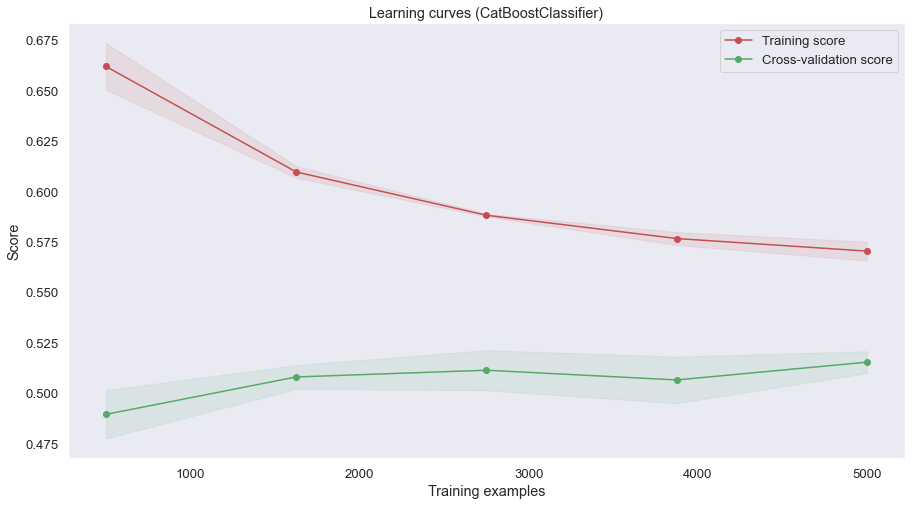

In [676]:
show_learning_curve_plot(final_model, X, y)

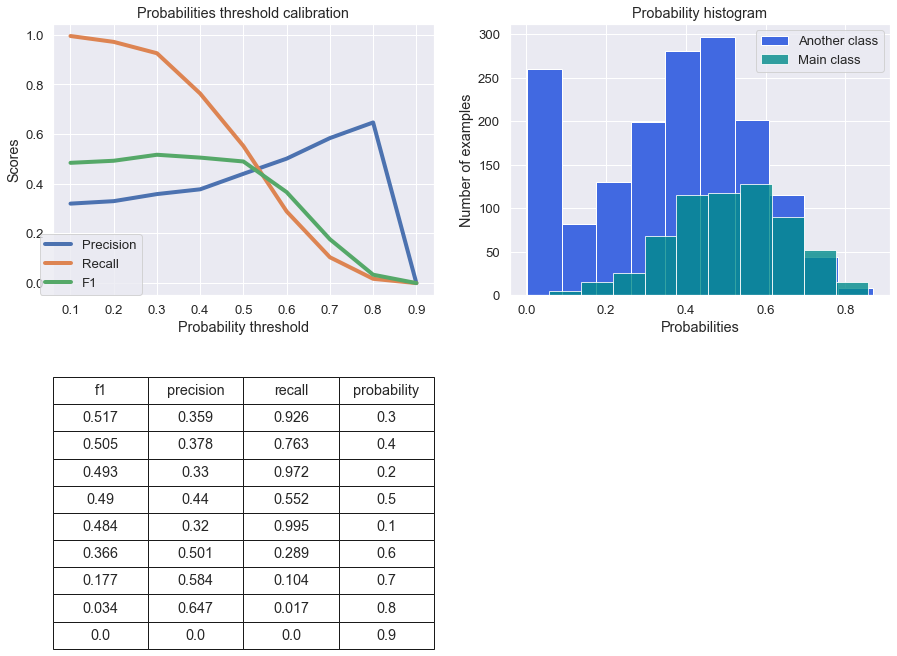

In [679]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

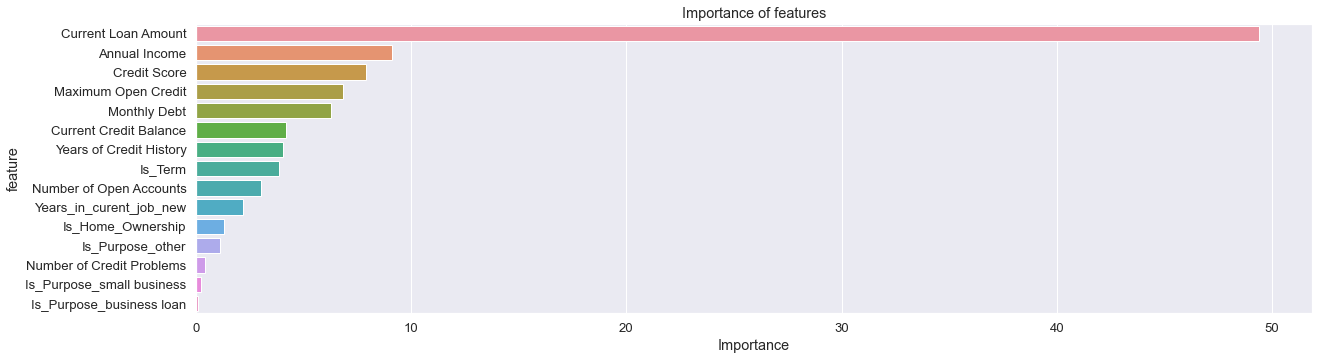

In [682]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)

In [683]:
important_features_top

['Current Loan Amount',
 'Annual Income',
 'Credit Score',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Years of Credit History',
 'Is_Term',
 'Number of Open Accounts',
 'Years_in_curent_job_new']

#### Финальная модель

In [684]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3771
           1       0.75      0.73      0.74      2958

    accuracy                           0.77      6729
   macro avg       0.77      0.77      0.77      6729
weighted avg       0.77      0.77      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.72      0.76      1616
           1       0.43      0.52      0.47       634

    accuracy                           0.67      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1171  445
1                305  329


#### Сохранение финальной модели

In [686]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### 10. Интерпретация результатов

In [687]:
y_result = final_model.predict(df_test[important_features_top])

In [688]:
result = pd.DataFrame({'ID': df_test['ID'], 'Credit Default': y_result})

In [689]:
result['Credit Default'].value_counts()

0    1682
1     818
Name: Credit Default, dtype: int64

In [690]:
result.to_csv(RESULT_FILE_PATH, index=False, encoding='utf-8')